In [1]:
import numpy as np
import open3d as o3d
import matplotlib.pyplot as plt
from utils.matrix import project_points, project_covariance, to_homogeneous
from utils.colmap_data import COLMAP_Data
from utils.plot_utils import create_ellipsoids_as_one_mesh, plot_covariance, plot_points
from src.gaussian import GaussianSplatting
from scipy.stats import chi2
import torch
try:
    import cuda_backend
except:
    from cuda_backend import add
    print('Need to fix cuda import')

Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.
Need to fix cuda import


In [2]:
colmap_data = COLMAP_Data("data/sparse/0")

frame_idx = 1
E = colmap_data.E[colmap_data.frame_names[frame_idx]]
K = colmap_data.K

distortion = colmap_data.distortion
points = colmap_data.points
colors = colmap_data.colors
width = colmap_data.width
height = colmap_data.height

# sample_idxes = np.arange(1000)
sample_idxes = np.arange(len(points))

E = torch.tensor(E, dtype=torch.float32)
K = torch.tensor(K, dtype=torch.float32)
points = torch.tensor(points[sample_idxes], dtype=torch.float32)
colors = torch.tensor(colors[sample_idxes], dtype=torch.float32)

points.shape

torch.Size([56042, 3])

In [3]:
# gaussians: full 3D covariance matrix Σ defined in world space
# 𝐺(𝑥) = 𝑒^(-0.5 * (𝑥T) Inv(Σ) (𝑥)
# gaussians_2d: Σ′ = 𝐽𝑊 Σ 𝑊𝑇 𝐽T


In [4]:
from scipy.spatial import KDTree

kdtree = KDTree(points)
distances, _ = kdtree.query(points, k=4)  # k=4 includes the point itself
nearest_distances = distances[:, 1:4]
mean_distances = nearest_distances.mean(axis=1)

In [5]:
def q2r(Q):
    batch_size = Q.size(0)
    R = torch.zeros((batch_size, 3, 3), dtype=Q.dtype, device=Q.device)
    
    R[:, 0, 0] = torch.ones_like(Q[:, 0]) - 2 * (Q[:, 2].pow(2) + Q[:, 3].pow(2))
    R[:, 0, 1] = 2 * (Q[:, 1] * Q[:, 2] - Q[:, 0] * Q[:, 3])
    R[:, 0, 2] = 2 * (Q[:, 3] * Q[:, 1] + Q[:, 0] * Q[:, 2])
    
    R[:, 1, 0] = 2 * (Q[:, 1] * Q[:, 2] + Q[:, 0] * Q[:, 3])
    R[:, 1, 1] = torch.ones_like(Q[:, 0]) - 2 * (Q[:, 1].pow(2) + Q[:, 3].pow(2))
    R[:, 1, 2] = 2 * (Q[:, 2] * Q[:, 3] - Q[:, 0] * Q[:, 1])
    
    R[:, 2, 0] = 2 * (Q[:, 3] * Q[:, 1] - Q[:, 0] * Q[:, 2])
    R[:, 2, 1] = 2 * (Q[:, 2] * Q[:, 3] + Q[:, 0] * Q[:, 1])
    R[:, 2, 2] = torch.ones_like(Q[:, 0]) - 2 * (Q[:, 1].pow(2) + Q[:, 2].pow(2))
    return R

In [6]:
# We estimate the initial covariance matrix as an isotropic Gaussian with axes equal to the mean of the distance to the closest three points
# To allow independent optimization of both factors, we store them separately:
# a 3D vector 𝑠 for scaling and a quaternion 𝑞 to represent rotation

## ----- initialize Q and S -----
q = torch.tensor([1, 0, 0, 0], dtype=torch.float32)
Q = torch.repeat_interleave(q.unsqueeze(0), len(points), dim=0)
Q = Q / torch.norm(Q, dim=1, keepdim=True)

s = torch.sqrt(torch.tensor(mean_distances, dtype=torch.float32))
S = torch.repeat_interleave(s.unsqueeze(1), 3, dim=1)

## ----- initialize Covariance Matrix -----
# Σ = 𝑅 𝑆 𝑆𝑇 𝑅T

Q.requires_grad = True
S.requires_grad = True

S_activation = torch.sigmoid(S)
S_diag = torch.diag_embed(S_activation)
R = q2r(Q)
L = (R @ S_diag)
G = L @ L.transpose(1, 2)

In [7]:
## ----- project gaussian to 2D -----
# Σ′ = 𝐽𝑊 Σ 𝑊𝑇T

def to_homogeneous(x):
    return torch.cat([x, torch.ones((len(x), 1))], dim=1)

mu_h = to_homogeneous(points)

mu_cam_h = mu_h @ E.T
mu_x = mu_cam_h[:, 0]
mu_y = mu_cam_h[:, 1]
mu_z = mu_cam_h[:, 2]

mu_cam = mu_cam_h[:, :2] / mu_z.unsqueeze(1)
mu_2d_h = to_homogeneous(mu_cam) @ K.T
mu_2d = mu_2d_h[:, :2]

J = torch.zeros((len(mu_cam), 2, 3))
fx, fy = K[0, 0], K[1, 1]

J[:, 0, 0] = fx / mu_z
J[:, 0, 2] = -fx * mu_x / mu_z**2
J[:, 1, 1] = fy / mu_z
J[:, 1, 2] = -fy * mu_y / mu_z**2

W = E[:3, :3] # (3,3) (R)
U = J @ W # (N, 2, 4)

G_2d = U @ G @ U.transpose(1, 2)

In [61]:
# clip to view frustum
scale_2d_squared, r_2d = torch.linalg.eigh(G_2d) # scale in 2d
G_scale = torch.sqrt(scale_2d_squared) * 2.3263 # 99% confidence interval

mu_min = mu_2d - G_scale
mu_max = mu_2d + G_scale

bound_indices = (mu_min[:, 0] > 0) & (mu_min[:, 1] > 0) & \
                (mu_max[:, 0] < width) & (mu_max[:, 1] < height) & \
                (mu_z > 0)

mu_2d_in = mu_2d[bound_indices]
colors_in = colors[bound_indices]
G_2d_in = G_2d[bound_indices]
G_scale_in = G_scale[bound_indices]

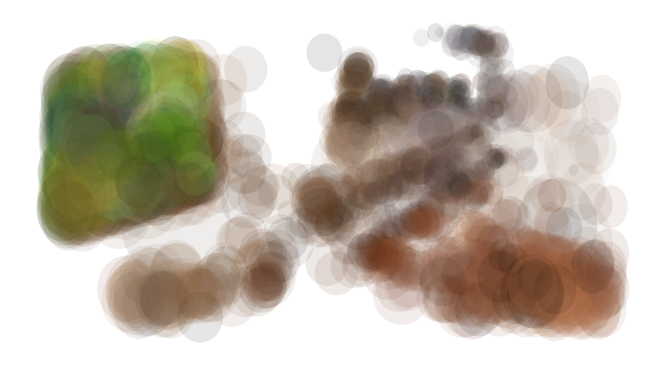

In [63]:
# plot with ellipses
from matplotlib.collections import EllipseCollection
fig, ax = plt.subplots()

plot_points = mu_2d_in.detach().numpy()

# ax.scatter(plot_points[:, 0], plot_points[:, 1], color=colors_in.numpy(), s=2)

# Create EllipseCollection
ec = EllipseCollection(
    widths=G_scale_in.detach().numpy()[:, 0],
    heights=G_scale_in.detach().numpy()[:, 1],
    angles=np.zeros(len(plot_points)),
    units='xy',
    offsets=plot_points,
    transOffset=ax.transData,
    facecolor=colors_in.numpy(),
    alpha=0.1
)
ax.add_collection(ec)
ax.set_aspect('equal')
ax.set_xlim(0, width)
ax.set_ylim(height, 0)
ax.axis('off')
plt.gca().set_position([0, 0, 1, 1])

plt.savefig('docs/images/rasterized_gaussian_00001.png',
            bbox_inches='tight', pad_inches=0)
plt.show()


In [74]:
loss = torch.mean(torch.linalg.inv(G_2d))

In [75]:
Q.grad = None
S.grad = None

In [76]:
loss.backward()


In [77]:
S.grad

tensor([[-3.5489e-08, -2.3312e-08, -2.7118e-10],
        [-5.2667e-09, -7.7291e-10, -5.6912e-09],
        [-9.1867e-09, -1.4412e-09, -1.3583e-09],
        ...,
        [-5.6518e-09, -7.3903e-10, -4.6988e-09],
        [-9.3981e-09, -3.8168e-09, -1.1387e-08],
        [-3.3430e-08, -1.3386e-08, -2.0576e-08]])

In [78]:
Q.grad

tensor([[0., 0., 0., 0.],
        [0., 0., 0., 0.],
        [0., 0., 0., 0.],
        ...,
        [0., 0., 0., 0.],
        [0., 0., 0., 0.],
        [0., 0., 0., 0.]])